# Cifar10 Classification

Until now, we have implemented several pieces of a deep learning pipeline and trained a two-layer neural network, but all hyperparameters were pre-set to values yielding resonable results. However, in real problems a large part of the work will be geared towards finding the best hyperparameter settings for a certain problem. In this notebook we will explore some good practices for network debugging and hyperparameters search, as well as extending our binary classification neural network to a multi-class one.

**Note**: This exercise is quite heavy with computations. We recommend using Google-Colab.

In [32]:
# setup
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

from .BNN import BayesianCNN

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

ImportError: attempted relative import with no known parent package

# CIFAR10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.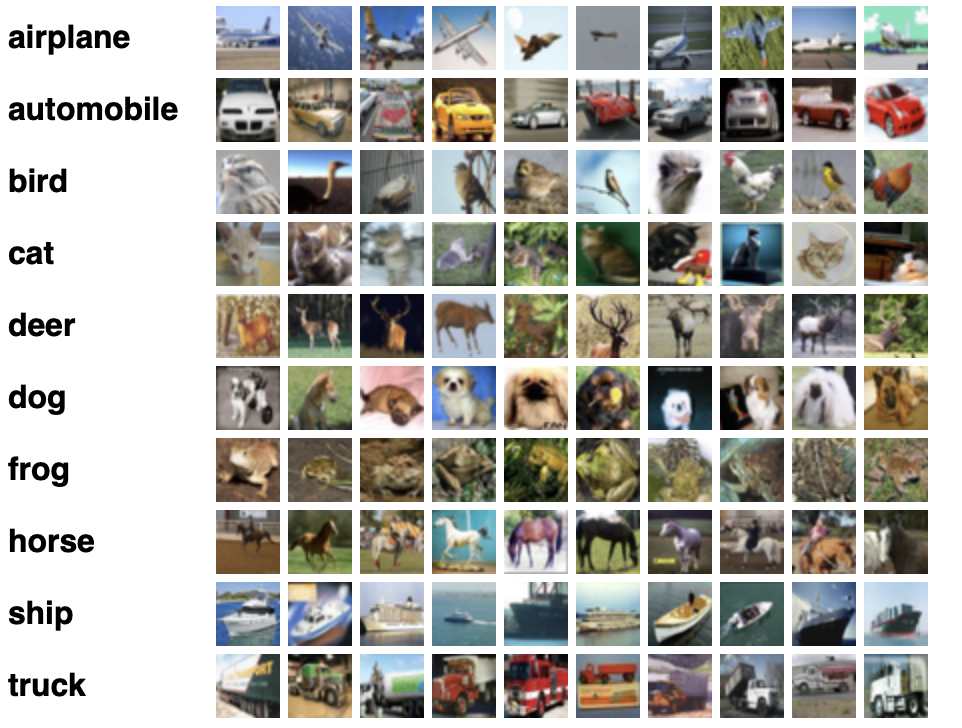
More infromation can be found in https://www.cs.toronto.edu/~kriz/cifar.html.

The dataset can be downloaded with the code below.

In [13]:
download_url = "https://www.dropbox.com/scl/fi/ws1183q0ulzjgh1sug8r4/cifar10.zip?rlkey=iwqddpmlnn3quo41sn2hjqyme&st=7w8ycd6q&dl=1"
project_path = os.path.dirname(os.path.abspath(os.getcwd()))
cifar_root = os.path.join(project_path, "datasets", "cifar10")

The dataset preprocessing and augmentation, and splitting to train, test, val sets is done below.

In [14]:
cifar_mean = np.array([0.49191375, 0.48235852, 0.44673872])
cifar_std  = np.array([0.24706447, 0.24346213, 0.26147554])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),              
    transforms.Normalize(cifar_mean, cifar_std),  
])

full_trainset = torchvision.datasets.CIFAR10(
    root=cifar_root, train=True, download=True, transform=transform
)

# 80% train, 20% validation+test
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testset = torchvision.datasets.CIFAR10(
    root=cifar_root, train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Checking the dataset loader size.

In [16]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")

Batch of images shape: torch.Size([64, 3, 32, 32])
Batch of labels shape: torch.Size([64])


Let's have a look at some samples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


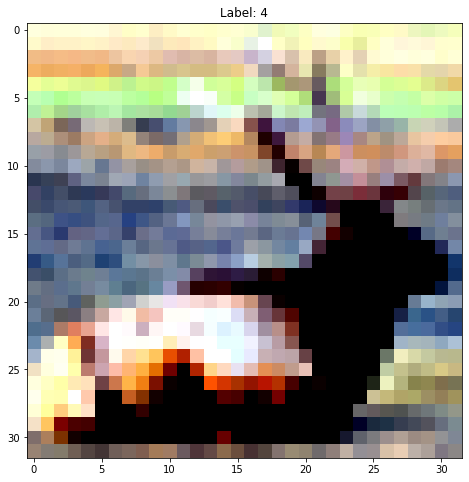

In [20]:
data_iter = iter(trainloader)
images, labels = next(data_iter)  

image = images[0]
label = labels[0]

image_np = image.numpy().transpose((1, 2, 0))

plt.imshow(image_np)
plt.title(f"Label: {label.item()}") 
plt.show()


# BayesianCNN: Training

Let's create our BayesanCNN model which is implemented in netword/BNN.py and print its structure.

In [26]:
model = BayesianCNN(prior_sigma=0.1)
print(model)

BayesianCNN(
  (conv1): BayesianConv2dFlipout()
  (conv2): BayesianConv2dFlipout()
  (conv3): BayesianConv2dFlipout()
  (conv4): BayesianConv2dFlipout()
  (fc1): BayesianDenseFlipout()
  (fc2): BayesianDenseFlipout()
  (fc3): BayesianDenseFlipout()
)


Defining functionality for training, validating and testing

In [27]:
# Training loop
def train(model, trainloader, valloader, optimizer, epochs=5):
    print("Starting the training")
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, stochastic=True)
            loss = compute_loss(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # compute validation loss and accuracy
        val_loss, val_accuracy = validate(model, valloader)
        
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(trainloader)}")
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%")

# Validation loop
def validate(model, valloader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = model(inputs, stochastic=False)
            loss = compute_loss(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Loss function
def compute_loss(output, target):
    return F.nll_loss(output, target)

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs, stochastic=False)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {100 * correct / total}%')


Setting the optimizer

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
print("Starting training")
train(model, trainloader, valloader, optimizer, epochs=5)

Starting training
Epoch 1, Training Loss: 1045333.6325875
Validation Loss: 2.302760101427698, Validation Accuracy: 10.02%
Epoch 2, Training Loss: 218606.308425
Validation Loss: 2.303038528770398, Validation Accuracy: 10.02%
Epoch 3, Training Loss: 95010.11465
Validation Loss: 2.3043688452167874, Validation Accuracy: 10.02%
Epoch 4, Training Loss: 49086.992815625
Validation Loss: 2.306514597242805, Validation Accuracy: 10.02%
Epoch 5, Training Loss: 27854.892893359374
Validation Loss: 2.309406125621431, Validation Accuracy: 10.02%


In [12]:
# Test the model after training
test(model, testloader)

Accuracy on the test set: 10.0%


For Bayesian neural networks, usually long training is applied. The 5 epochs on whcih the BayesianCNN has been trained, gave accuracy of about 10%. This suggests that, first of all, the training epochs should be increased, before thinking about changing the architecture. For simplicity, a small portion of dataset is used for training for 20 epochs.

In [31]:
subset_size = int(len(full_trainset) * 0.2)  # 20% of the training data
train_subset, _ = random_split(trainset, [subset_size, len(trainset) - subset_size])

trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)

In [13]:
train(model, trainloader, valloader, optimizer, epochs=20)

Starting the training
Epoch 1, Training Loss: 3117324.70660828
Validation Loss: 2.302572999030921, Validation Accuracy: 10.59%
Epoch 2, Training Loss: 2977578.833598726
Validation Loss: 2.302578226016585, Validation Accuracy: 10.23%
Epoch 3, Training Loss: 2536181.354299363
Validation Loss: 2.302575005087883, Validation Accuracy: 10.06%
Epoch 4, Training Loss: 2384334.585589172
Validation Loss: 2.3025738874058814, Validation Accuracy: 10.59%
Epoch 5, Training Loss: 2031027.7348726115
Validation Loss: 2.3025717355643107, Validation Accuracy: 10.59%
Epoch 6, Training Loss: 2086194.6827229299
Validation Loss: 2.302582714967667, Validation Accuracy: 9.91%
Epoch 7, Training Loss: 1855316.5382165606
Validation Loss: 2.3025800832517587, Validation Accuracy: 9.91%
Epoch 8, Training Loss: 1582660.0638933121
Validation Loss: 2.3025729686591276, Validation Accuracy: 9.91%
Epoch 9, Training Loss: 1520912.1248009554
Validation Loss: 2.3025746937769993, Validation Accuracy: 9.91%
Epoch 10, Training 

Training on a subset of training set for 20 epochs still result in 10% accuracy. The model will be trained on the whole training dataset for 100 epochs in the future, to see if the model arcitecture is capable of learning or not.